# IBM Data Science Capstone Project: *Battle of Neighbourhoods*

**The idea behind the project:**
Define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to solve or execute.

## Idea

**Background:** 
Europe with its Eurozone is a perfect place for people who likes work travelling. My freind Bart, currently is living in Warsaw, Poland, and looking to move to some other city in Europe that is as comfortable as Warsaw but with higher income. I think Bart is not alone with such idea in mind, hence categorizing european cities by similarities and higher income will be a usefull info. 
<br/>
**Approach:** 
Build a model that will classify and group european cities to help Bart narrow the list of the cities to choose from.

P.S.: *Bart knows that I am studying Data Science and asked to help him with this question.*

**Data**

To perform this analysis I will need a list of largest European cities, their geolocation and GDP per capita.

* List of European largest cities (euro_cities.csv) + population, from: https://ec.europa.eu/eurostat/databrowser/view/urb_cpop1/default/table?lang=en
* Geolocation is obtained using geopy library and foresquare (in some cases frsq api works better identifying european cities on the map) 
* City attractions: foresquare - list of venues
* GDP per city (gdp.csv): https://ec.europa.eu/eurostat
* Annual weather report: https://weatherspark.com

In [858]:
#Web scraping
import requests
from bs4 import BeautifulSoup as bs4

#Data manipulation
import pandas as pd
import numpy as np

#Visualization
import folium
from matplotlib import pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

#Geocords
from geopy.geocoders import Nominatim

### Data collection and preprocessing

The base of the data model will be list of european cities with total population from 2017 to 2019 year. The rest of data will be tied up to this main data drame.

In [380]:
cities = pd.read_csv('data/euro_cities.csv',encoding='utf8')
cities.columns = ['city','2017','2018','2019']
cities.head()

,city,2017,2018,2019
0,Belgium,11351727,11398589,11455519
1,Bruxelles / Brussel,1199095,1205492,1215289
2,Antwerpen,520859,523591,526439
3,Gent,259462,260329,262205
4,Charleroi,201884,202341,202637


As you might notice first element "Belgium" - country. The following are the cities of Belgium. Lets create an additional column where we would classify conventions.

In [381]:
#get list of countries
countries = pd.read_csv('data/countries.csv',encoding='utf8')
countries = list(countries['Country'])

isCountry = [True if x in countries else False for x in cities.city]
cities['isCountry'] = isCountry
cities.head()

,city,2017,2018,2019,isCountry
0,Belgium,11351727,11398589,11455519,True
1,Bruxelles / Brussel,1199095,1205492,1215289,False
2,Antwerpen,520859,523591,526439,False
3,Gent,259462,260329,262205,False
4,Charleroi,201884,202341,202637,False


Lets create a separate column to track countries for cities

In [382]:
cities.loc[cities.isCountry==True,'country'] = cities.loc[cities.isCountry==True,'city']
cities.country.fillna(method='ffill', inplace=True)
cities.head()

,city,2017,2018,2019,isCountry,country
0,Belgium,11351727,11398589,11455519,True,Belgium
1,Bruxelles / Brussel,1199095,1205492,1215289,False,Belgium
2,Antwerpen,520859,523591,526439,False,Belgium
3,Gent,259462,260329,262205,False,Belgium
4,Charleroi,201884,202341,202637,False,Belgium


We actually do not need all three year of statistics on populations, we just need the latest data. Hence, lets populate empty records for 2019 with records from previous years.

In [383]:
cities.replace(':',np.nan,inplace=True)
cities['2019'].isnull().sum()

572

In [384]:
cities.loc[cities['2019'].isnull(),'2019'] = cities.loc[cities['2019'].isnull(),'2018']
cities.loc[cities['2019'].isnull(),'2019'] = cities.loc[cities['2019'].isnull(),'2017']
#cities['2019'].isna().sum()
#Dropping the rest
cities = cities.loc[cities['2019'].notnull(),:]
print(cities['2019'].isna().sum(),cities.shape)

0 (844, 6)


And finally dropping the rest 2017, 2018 columns

In [385]:
cities.drop(['2017','2018'], axis=1, inplace=True)
cities.rename(columns={'2019':'population'},inplace=True)
print(cities.shape)
cities.head()

(844, 4)


,city,population,isCountry,country
0,Belgium,11455519,True,Belgium
1,Bruxelles / Brussel,1215289,False,Belgium
2,Antwerpen,526439,False,Belgium
3,Gent,262205,False,Belgium
4,Charleroi,202637,False,Belgium


##### Processing GDP Data

Now as we have List of cities collected with its population, lets add GDP the table.

In [386]:
gdp = pd.read_csv('data/gdp_euro.csv')
gdp.drop(['UNIT'],axis=1,inplace=True)
gdp.columns = ['city','2017','2018','2019']
print(gdp.shape)
gdp.head()

(346, 4)


,city,2017,2018,2019
0,Belgium,430372.10,446364.90,459819.80
1,Bruxelles / Brussel,134293.37,137974.75,141689.31
2,Antwerpen,48646.35,50478.13,52137.95
3,Gent,27470.15,28830.02,29916.27
4,Charleroi,11384.32,11689.12,11682.73


Lets check GDP for empty value and clear them if any.

In [387]:
gdp.replace(':',np.nan,inplace=True)
gdp['2019'].isnull().sum()

242

In [388]:
gdp.loc[gdp['2019'].isnull(),'2019'] = gdp.loc[gdp['2019'].isnull(),'2018']
gdp.loc[gdp['2019'].isnull(),'2019'] = gdp.loc[gdp['2019'].isnull(),'2017']
#cities['2019'].isna().sum()
#Dropping the rest
gdp = gdp.loc[gdp['2019'].notnull(),:]
print(gdp['2019'].isna().sum(),gdp.shape)

0 (344, 4)


Now lets remove previous years and update column names

In [389]:
gdp.drop(['2017','2018'], axis=1, inplace=True)
gdp.rename(columns={'2019':'gdp'},inplace=True)
print(gdp.shape)
gdp.head()

(344, 2)


,city,gdp
0,Belgium,459819.80
1,Bruxelles / Brussel,141689.31
2,Antwerpen,52137.95
3,Gent,29916.27
4,Charleroi,11682.73


Also GDP data contains some 'Non-metropolitan area' estimations for some countries, removing these. And lets remove country figueres.

In [390]:
gdp = gdp[~gdp.city.str.contains('Non-metro')]
gdp.shape

(316, 2)

Lets add out GDP figures to cities data frame

In [391]:
cities = pd.merge(cities, gdp, on='city')

In [392]:
print(cities[cities.isCountry==False].shape)
cities[cities.isCountry==False].head()

(226, 5)


,city,population,isCountry,country,gdp
1,Bruxelles / Brussel,1215289,False,Belgium,141689.31
2,Antwerpen,526439,False,Belgium,52137.95
3,Gent,262205,False,Belgium,29916.27
4,Charleroi,202637,False,Belgium,11682.73
5,Liège,383482,False,Belgium,21195.70


Removing double city names and diplicated rows if any.

In [393]:
cities.loc[cities.city.str.contains('/'),'city'] = [x.split('/')[0].strip() for x in cities.loc[cities.city.str.contains('/'),'city']]
cities.city.replace('([(|)])','',regex=True, inplace=True)
cities.drop_duplicates(subset='city', keep='last', inplace=True)
cities.head()

,city,population,isCountry,country,gdp
0,Belgium,11455519,True,Belgium,459819.80
1,Bruxelles,1215289,False,Belgium,141689.31
2,Antwerpen,526439,False,Belgium,52137.95
3,Gent,262205,False,Belgium,29916.27
4,Charleroi,202637,False,Belgium,11682.73


From my experience geopy is providing bad quality data, especially for europe. Therefore, I used Foreqsquare venue API to find places **nearby**, this endpoint retuns as well coordinated of the cities.

Catching coordinates by city name.

In [397]:
CLIENT_ID = 'Y4SPYFQGWXXVGSNSI3M5PARWTNYUBHWCHXQYD2BJA5VP3PFA' # your Foursquare ID
CLIENT_SECRET = 'U4TXUQUZFRDVPRKBF4TL5RS5VQTDKUU4QNEE2ZFHG2AZW0YN' # your Foursquare Secret
VERSION = '20190101' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Y4SPYFQGWXXVGSNSI3M5PARWTNYUBHWCHXQYD2BJA5VP3PFA
CLIENT_SECRET:U4TXUQUZFRDVPRKBF4TL5RS5VQTDKUU4QNEE2ZFHG2AZW0YN


In [398]:
long = []
lat = []

radius = 5000
offset = 0
LIMIT = 1

for index, row in cities.iterrows():
    try:
        near = row['city']
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}&offset={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                near, 
                radius, 
                LIMIT,
                offset)
        results = requests.get(url).json()["response"]['geocode']['center']
        lat.append(results['lat'])
        long.append(results['lng'])
    except:
        lat.append(None)
        long.append(None)

cities['latitude_frsq'] = lat
cities['longitude_frsq'] = long
cities = cities[~cities.latitude_frsq.isnull()]
cities.head()

,city,population,isCountry,country,gdp,latitude,longitude,latitude_frsq,longitude_frsq
0,Belgium,11455519,True,Belgium,459819.80,50.640281,4.666715,50.75000,4.50000
1,Bruxelles,1215289,False,Belgium,141689.31,50.846557,4.351697,50.85045,4.34878
2,Antwerpen,526439,False,Belgium,52137.95,51.221110,4.399708,51.21989,4.40346
3,Gent,262205,False,Belgium,29916.27,51.053829,3.725012,51.05000,3.71667
4,Charleroi,202637,False,Belgium,11682.73,50.412033,4.443624,50.41136,4.44448


Getting Europe location

In [400]:
location = geolocator.geocode('Europe')
print('Europe geolocation: {}, {}'.format(location.latitude, location.longitude))
latitude = location.latitude
longitude = location.longitude

Europe geolocation: 51.0, 10.0


So far so good, lets see our cities on tha map

In [401]:
cities = cities[(cities['longitude']<38) & (cities['longitude']>-14)]

# create map of Manhattan using latitude and longitude values
europe_map = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for lat, lng, label in zip(cities[cities.isCountry==False]['latitude_frsq'], cities[cities.isCountry==False]['longitude_frsq'], cities[cities.isCountry==False]['city']):
    label = folium.Popup(label + f' {lat}, {lng}', parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(europe_map)  
    
europe_map

Now as we have coordinated lets gather foresquare data on top venues in city. Since cities are of different size lets consider only center city attractions in the 5 km radius.

From the Foursquare lab in the previous module, we know that all the information is in the _items_ key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [402]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Lets utilize the function from lab to get list of venues for a certain adress

In [370]:
city_latitude = cities['latitude_frsq'] #  latitude value
city_longitude = cities['longitude_frsq'] #  longitude value
city_name = cities['city'] # city name

In [409]:
LIMIT = 100
radius=5000

names, latitudes, longitudes = city_name, city_latitude, city_longitude

venues_list=[]
for name, lat, lng in zip(names, latitudes, longitudes):
    print(name, end=' ')

    # create the API request URL
    offset =0
    for i in range(5):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            offset)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        offset += len(results)
    print(offset, end=' ')
nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['city', 
              'city latitude', 
              'city longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']

Warszawa 240 Kraków 237 Gdansk 184 

Now lets see how many venues we have per city.

In [431]:
city_venues = nearby_venues
city_venues.shape

(28947, 7)

In [432]:
print('There are {} uniques categories.'.format(len(city_venues['Venue Category'].unique())))

There are 550 uniques categories.


In [433]:
city_venues.groupby('city').count()

,city latitude,city longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
city,,,,,,
A Coruña,117,117,117,117,117,117
Aachen,173,173,173,173,173,173
Amiens,70,70,70,70,70,70
Angers,69,69,69,69,69,69
Antwerpen,234,234,234,234,234,234
...,...,...,...,...,...,...
Wuppertal,86,86,86,86,86,86
Würzburg,113,113,113,113,113,113
Zagreb,187,187,187,187,187,187


#### Analyze each city

In [429]:
# one hot encoding
cities_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cities_onehot['city'] = city_venues['city']


# move neighborhood column to the first column
fixed_columns = ['city'] + [x for x in cities_onehot.columns.tolist() if x!='city']
cities_onehot = cities_onehot[fixed_columns]

cities_onehot.head()

,city,ATM,Abruzzo Restaurant,Acai House,Accessories Store,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Bruxelles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bruxelles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bruxelles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bruxelles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bruxelles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [434]:
cities_onehot.shape

(28947, 551)

#### Now lets get averages for city based on the venue category

In [435]:
cities_grouped = cities_onehot.groupby('city').mean().reset_index()
cities_grouped

,city,ATM,Abruzzo Restaurant,Acai House,Accessories Store,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,A Coruña,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.034188,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,Aachen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.005780,0.000000,0.0,0.0,0.000000,0.0,0.0,0.005780,0.000000
2,Amiens,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.014286,0.000000
3,Angers,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.014493,0.014493,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,Antwerpen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.004274,0.000000,0.0,0.0,0.004274,0.0,0.0,0.004274,0.004274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Wuppertal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
199,Würzburg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.026549,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
200,Zagreb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.010695,0.000000,0.0,0.0,0.000000,0.0,0.0,0.005348,0.000000
201,Zaragoza,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


#### Now lets create a new dataframe for top vanues in cities. However, number of venue categories is pretty large hence lets stick with 30 top venues.

First, let's write a function to sort the venues in descending order.


In [436]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Build a new DF

In [442]:
num_top_venues = 30

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city']
for ind in np.arange(num_top_venues):
    indx = str(ind+1)[-1]
    if indx == '1':
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[0]))
    elif indx == '2':
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[1]))
    elif indx == '3':
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[2]))
    else:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['city'] = cities_grouped['city']

for ind in np.arange(cities_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

print(cities_venues_sorted.shape)
cities_venues_sorted.head()

(203, 31)


,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,21st Most Common Venue,22nd Most Common Venue,23rd Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
0,A Coruña,Spanish Restaurant,Restaurant,Beach,Park,Plaza,Tapas Restaurant,Hotel,Wine Bar,Seafood Restaurant,...,Garden,Mediterranean Restaurant,Beer Bar,Food,Tea Room,Cupcake Shop,Big Box Store,Bookstore,Sushi Restaurant,Theater
1,Aachen,Supermarket,Café,Italian Restaurant,German Restaurant,Bakery,Bar,Drugstore,Plaza,Greek Restaurant,...,Gastropub,Pub,Outlet Store,Discount Store,Mediterranean Restaurant,Chinese Restaurant,Cocktail Bar,Snack Place,Scenic Lookout,Shopping Mall
2,Amiens,Supermarket,Bar,Hotel,French Restaurant,Fast Food Restaurant,Shopping Mall,Park,Plaza,Performing Arts Venue,...,Brewery,Gas Station,Golf Course,Convenience Store,Cosmetics Shop,Café,Burger Joint,Sporting Goods Shop,Pizza Place,Soccer Stadium
3,Angers,Bar,Park,French Restaurant,Supermarket,Hotel,Tram Station,Restaurant,Beer Garden,Shopping Mall,...,Japanese Restaurant,Miscellaneous Shop,Opera House,Farmers Market,Movie Theater,Museum,Music Venue,Brewery,Nightclub,Trail
4,Antwerpen,Bar,Coffee Shop,Italian Restaurant,French Restaurant,Cocktail Bar,Bakery,Gym,Park,Supermarket,...,Breakfast Spot,Steakhouse,Fast Food Restaurant,Pizza Place,Cosmetics Shop,Gym / Fitness Center,Sandwich Place,Thai Restaurant,Concert Hall,Juice Bar


And finally lets add our GDP and population to table.

In [446]:
cities_venues_sorted = pd.merge(cities_venues_sorted, cities[['city','population','gdp']], on='city')
cities_venues_sorted.shape

(202, 33)

GDP and population are not accurate representation of economic level of city. Therefore, lets calculate GDP per Capita to have common measure to compare cities. 

In [456]:
cities_venues_sorted.gdp = cities_venues_sorted.gdp.astype('float')
cities_venues_sorted.population = cities_venues_sorted.population.astype('float')

In [457]:
cities_venues_sorted['GdpPerCap'] = cities_venues_sorted.gdp / cities_venues_sorted.population
cities_venues_sorted.drop(['gdp','population'], axis=1, inplace=True)
cities_venues_sorted.head()

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,22nd Most Common Venue,23rd Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,GdpPerCap
0,A Coruña,Spanish Restaurant,Restaurant,Beach,Park,Plaza,Tapas Restaurant,Hotel,Wine Bar,Seafood Restaurant,...,Mediterranean Restaurant,Beer Bar,Food,Tea Room,Cupcake Shop,Big Box Store,Bookstore,Sushi Restaurant,Theater,0.106404
1,Aachen,Supermarket,Café,Italian Restaurant,German Restaurant,Bakery,Bar,Drugstore,Plaza,Greek Restaurant,...,Pub,Outlet Store,Discount Store,Mediterranean Restaurant,Chinese Restaurant,Cocktail Bar,Snack Place,Scenic Lookout,Shopping Mall,0.083495
2,Amiens,Supermarket,Bar,Hotel,French Restaurant,Fast Food Restaurant,Shopping Mall,Park,Plaza,Performing Arts Venue,...,Gas Station,Golf Course,Convenience Store,Cosmetics Shop,Café,Burger Joint,Sporting Goods Shop,Pizza Place,Soccer Stadium,0.109353
3,Angers,Bar,Park,French Restaurant,Supermarket,Hotel,Tram Station,Restaurant,Beer Garden,Shopping Mall,...,Miscellaneous Shop,Opera House,Farmers Market,Movie Theater,Museum,Music Venue,Brewery,Nightclub,Trail,0.120917
4,Antwerpen,Bar,Coffee Shop,Italian Restaurant,French Restaurant,Cocktail Bar,Bakery,Gym,Park,Supermarket,...,Steakhouse,Fast Food Restaurant,Pizza Place,Cosmetics Shop,Gym / Fitness Center,Sandwich Place,Thai Restaurant,Concert Hall,Juice Bar,0.099039


### Weather scraper

Here I'll be using 2 the most popular and efficient packages: *BeautifulSoup* and *Selenium*. As you already know from training BS is sed to parse html of webpages and serch for elements inside. *Selenium*  is another great tool that allowes you to simulate user actions like clicks, keystrokes and mouse moves in the browser in case scraping require some manual operations.

In [467]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys

Creating instance of the browser

In [649]:
chromedriver = 'R:/Python/drivers/chromedriver.exe'
options = webdriver.ChromeOptions()
options.add_argument('headless')  # for opening headless browser

In [663]:
browser = webdriver.Chrome(executable_path=chromedriver, options=options)

Scraping weather report from **weatherspark.com**

In [687]:
from IPython.display import clear_output
data_list = []
search_results = []
soup = ''
counter = 1
l_cities = cities_venues_sorted.city
for city in l_cities:
    clear_output(wait=True)
    print('scraping for: {} \n{}:{}'.format(city,counter,len(l_cities)))   
    counter += 1
    data = []
    #Navigating to weather summary
    browser.get('https://weatherspark.com/')
    try:
        WebDriverWait(browser, 5).until(EC.presence_of_all_elements_located((By.TAG_NAME,'html')))
    except TimeoutException:
        'Loading too long!'
        
    search_box = browser.find_element_by_class_name('LiveSearch-FrontPage-field')
    search_box.send_keys(city)
    
    wait = WebDriverWait(browser, 10)
    men_menu = wait.until(EC.visibility_of_element_located((By.XPATH, "//*[@id='LiveSearch-FrontPage-Container']/div/div[1]")))
    ActionChains(browser).move_to_element(men_menu).perform()
    
    search_box.send_keys(Keys.ENTER)
    #first_item = WebDriverWait(browser, 10).until(EC.visibility_of_element_located((By.XPATH, "//*[@id='LiveSearch-FrontPage-Container']/div/div[1]")))
    #text1 = first_item.text
    #print(text1)
    #search_results.append(text1)
    #first_item = WebDriverWait(browser, 10).until(EC.visibility_of_element_located((By.XPATH, "//*[@id='LiveSearch-FrontPage-Container']/div/div[1]")))
    #first_item.click()
    
    try:
        WebDriverWait(browser, 5).until(EC.presence_of_all_elements_located((By.CLASS_NAME,'Section-body charts_only_do_hide')))
    except TimeoutException:
        'Loading too long!'
    
    #converting html
    html = browser.page_source
    soup = bs4(html, 'html')
    
    #Collecting data
    text_cells = soup.find_all('div',{'class':'Section-body charts_only_do_hide'})
    
    #Tempreture
    text_inside = text_cells[1].findAll('p')
    warm_season = text_inside[0].findAll('em')
    data.extend([warm_season[1].text,warm_season[4].text,warm_season[6].text,warm_season[7].text]) #len_warm,avg_warm_temp,highest_warm,lowest_warm
    
    cold_season = text_inside[1].findAll('em')
    data.extend([cold_season[1].text,cold_season[4].text,cold_season[6].text,cold_season[7].text]) #len_cold,avg_cold_temp,lowest_cold,highest_cold
    
    #Cloudiness
    text_inside = text_cells[2].findAll('p')
    seasonal_var = text_inside[0].findAll('em')
    data.append(seasonal_var[0].text) #seasonal variation
    
    clearer_season = text_inside[1].findAll('em')
    data.extend([clearer_season[2].text,clearer_season[9].text]) #len_clearer, clear
    
    clody_season = text_inside[2].findAll('em')
    data.extend([clearer_season[2].text,clearer_season[9].text]) #len_cloudy, cloudy
    
    #SunLight
    text_inside = text_cells[4].findAll('p')
    day_light = text_inside[0].findAll('em')
    data.extend([day_light[1].text,day_light[3].text]) #shortest, longest day
    
    data_list.append(data)

scraping for: Zwickau 
5:5


The scraper worked well, excpet one city: Kirklees, so I propose to just simply remove it from all datasets.

In [692]:
cities = cities[cities.city != 'Kirklees']
cities_venues_sorted = cities_venues_sorted[cities_venues_sorted.city != 'Kirklees']
cities_grouped = cities_grouped[cities_grouped.city != 'Kirklees']

In [816]:
cities.reset_index(inplace=True)
cities_venues_sorted.reset_index(inplace=True)
cities_grouped.reset_index(inplace=True)

In [879]:
df = pd.DataFrame(data_list)
df.columns = ['len_warm','avg_warm_temp','highest_warm','lowest_warm','len_cold','avg_cold_temp','lowest_cold','highest_cold','seasonal_var','len_clearer','clear','len_cloudy','cloudy','shortest_day','longest_day']
df.head()

,len_warm,avg_warm_temp,highest_warm,lowest_warm,len_cold,avg_cold_temp,lowest_cold,highest_cold,seasonal_var,len_clearer,clear,len_cloudy,cloudy,shortest_day,longest_day
0,3.2 months,71°F,75°F,60°F,3.8 months,60°F,44°F,57°F,significant,3.2 months,77%,3.2 months,77%,"8 hours, 58 minutes","15 hours, 25 minutes"
1,3.1 months,66°F,73°F,57°F,3.7 months,47°F,32°F,41°F,significant,6.6 months,56%,6.6 months,56%,"7 hours, 57 minutes","16 hours, 30 minutes"
2,2.9 months,68°F,74°F,56°F,3.7 months,49°F,34°F,44°F,significant,6.2 months,60%,6.2 months,60%,"8 hours, 5 minutes","16 hours, 21 minutes"
3,3.1 months,72°F,78°F,58°F,3.7 months,53°F,36°F,48°F,significant,4.9 months,66%,4.9 months,66%,"8 hours, 27 minutes","15 hours, 58 minutes"
4,3.0 months,68°F,74°F,58°F,3.7 months,49°F,34°F,44°F,significant,6.6 months,58%,6.6 months,58%,"7 hours, 53 minutes","16 hours, 35 minutes"


In [1008]:
df.to_csv('weather.csv')

Lets now convert all data to appropriate formats.

In [881]:
weather = df[[x for x in df.columns if x not in ['seasonal_var','shortest_day','longest_day']]]

In [882]:
for col in weather:
    weather[col] = weather[col].str.replace(r'( months|°F|%)','', regex=True).astype('float')
weather = pd.concat([weather, df[['seasonal_var','shortest_day','longest_day']]],axis=1)
weather.head()

<ipython-input-882-9b88b215afb2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather[col] = weather[col].str.replace(r'( months|°F|%)','', regex=True).astype('float')


,len_warm,avg_warm_temp,highest_warm,lowest_warm,len_cold,avg_cold_temp,lowest_cold,highest_cold,len_clearer,clear,len_cloudy,cloudy,seasonal_var,shortest_day,longest_day
0,3.2,71.0,75.0,60.0,3.8,60.0,44.0,57.0,3.2,77.0,3.2,77.0,significant,"8 hours, 58 minutes","15 hours, 25 minutes"
1,3.1,66.0,73.0,57.0,3.7,47.0,32.0,41.0,6.6,56.0,6.6,56.0,significant,"7 hours, 57 minutes","16 hours, 30 minutes"
2,2.9,68.0,74.0,56.0,3.7,49.0,34.0,44.0,6.2,60.0,6.2,60.0,significant,"8 hours, 5 minutes","16 hours, 21 minutes"
3,3.1,72.0,78.0,58.0,3.7,53.0,36.0,48.0,4.9,66.0,4.9,66.0,significant,"8 hours, 27 minutes","15 hours, 58 minutes"
4,3.0,68.0,74.0,58.0,3.7,49.0,34.0,44.0,6.6,58.0,6.6,58.0,significant,"7 hours, 53 minutes","16 hours, 35 minutes"


Still we time columns (shortest and longest day) provided in string format, lets convert them to digits by equilanet of total minutes.

In [883]:
weather.shortest_day = weather.shortest_day.apply(lambda x: re.findall(r'\d+',x))
weather.longest_day = weather.longest_day.apply(lambda x: re.findall(r'\d+',x))
weather.head()

,len_warm,avg_warm_temp,highest_warm,lowest_warm,len_cold,avg_cold_temp,lowest_cold,highest_cold,len_clearer,clear,len_cloudy,cloudy,seasonal_var,shortest_day,longest_day
0,3.2,71.0,75.0,60.0,3.8,60.0,44.0,57.0,3.2,77.0,3.2,77.0,significant,"[8, 58]","[15, 25]"
1,3.1,66.0,73.0,57.0,3.7,47.0,32.0,41.0,6.6,56.0,6.6,56.0,significant,"[7, 57]","[16, 30]"
2,2.9,68.0,74.0,56.0,3.7,49.0,34.0,44.0,6.2,60.0,6.2,60.0,significant,"[8, 5]","[16, 21]"
3,3.1,72.0,78.0,58.0,3.7,53.0,36.0,48.0,4.9,66.0,4.9,66.0,significant,"[8, 27]","[15, 58]"
4,3.0,68.0,74.0,58.0,3.7,49.0,34.0,44.0,6.6,58.0,6.6,58.0,significant,"[7, 53]","[16, 35]"


In [884]:
def convert_to_m(digits):
    if len(digits)==2:
        return float(digits[0]) * 60 + float(digits[1])
    else:
        return float(digits[0]) * 60

In [885]:
weather.shortest_day = weather.shortest_day.apply(convert_to_m)
weather.longest_day = weather.longest_day.apply(convert_to_m)
print(weather.shape)
weather.head()

(201, 15)


,len_warm,avg_warm_temp,highest_warm,lowest_warm,len_cold,avg_cold_temp,lowest_cold,highest_cold,len_clearer,clear,len_cloudy,cloudy,seasonal_var,shortest_day,longest_day
0,3.2,71.0,75.0,60.0,3.8,60.0,44.0,57.0,3.2,77.0,3.2,77.0,significant,538.0,925.0
1,3.1,66.0,73.0,57.0,3.7,47.0,32.0,41.0,6.6,56.0,6.6,56.0,significant,477.0,990.0
2,2.9,68.0,74.0,56.0,3.7,49.0,34.0,44.0,6.2,60.0,6.2,60.0,significant,485.0,981.0
3,3.1,72.0,78.0,58.0,3.7,53.0,36.0,48.0,4.9,66.0,4.9,66.0,significant,507.0,958.0
4,3.0,68.0,74.0,58.0,3.7,49.0,34.0,44.0,6.6,58.0,6.6,58.0,significant,473.0,995.0


In [886]:
weather['city'] = cities_venues_sorted.city

In [887]:
cities_final = pd.merge(cities_grouped, weather, on='city')
cities_final.drop('index',axis=1,inplace=True)
cities_final.shape

(201, 566)

In [889]:
cities_final = pd.merge(cities_final,cities_venues_sorted[['city','GdpPerCap']],on='city')
cities_final.shape

(201, 567)

### Normalize data

In [832]:
from sklearn import preprocessing

In [890]:
cities_final_cluterizing = cities_final.drop('city',1)

In [891]:
#Columns to normalize
cols_norm = ['len_warm','avg_warm_temp','highest_warm',
             'lowest_warm','len_cold','avg_cold_temp',
             'lowest_cold','highest_cold','len_clearer',
             'clear','len_cloudy','cloudy','shortest_day','longest_day','GdpPerCap']

In [892]:
cities_final_cluterizing[cols_norm] = preprocessing.normalize(cities_final_cluterizing[cols_norm])

In [893]:
cities_final_cluterizing.head()

,ATM,Abruzzo Restaurant,Acai House,Accessories Store,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,...,lowest_cold,highest_cold,len_clearer,clear,len_cloudy,cloudy,seasonal_var,shortest_day,longest_day,GdpPerCap
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.040505,0.052472,0.002946,0.070884,0.002946,0.070884,significant,0.495264,0.851523,0.000098
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028832,0.036941,0.005947,0.050455,0.005947,0.050455,significant,0.429772,0.891979,0.000075
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.030737,0.039777,0.005605,0.054241,0.005605,0.054241,significant,0.438449,0.886843,0.000099
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.032800,0.043733,0.004464,0.060133,0.004464,0.060133,significant,0.461934,0.872845,0.000110
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.030538,0.039520,0.005928,0.052095,0.005928,0.052095,significant,0.424844,0.893699,0.000089


Encoding seasonal variance

In [895]:
# generate binary values using get_dummies
dum_df = pd.get_dummies(cities_final_cluterizing, columns=["seasonal_var"], prefix=["sv"] )
# merge with main df bridge_df on key values
cities_final_cluterizing = dum_df

### Clustering

In [930]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_final_cluterizing)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 4, 5, 5, 1, 4, 4, 3, 3, 4])

In [931]:
cities_merged = cities[cities.isCountry == False][['city','population','gdp','latitude_frsq','longitude_frsq']]
cities_merged.shape

(202, 5)

In [932]:
# add clustering labels
#cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
cities_venues_sorted['Cluster Labels'] = kmeans.labels_

In [933]:
cities_merged = pd.merge(cities_merged,cities_venues_sorted, on='city')

In [998]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

In [935]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_merged['latitude_frsq'], cities_merged['longitude_frsq'], cities_merged['city'], cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [936]:
cities_merged.groupby('Cluster Labels').count()

,city,population,gdp,latitude_frsq,longitude_frsq,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,22nd Most Common Venue,23rd Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,GdpPerCap
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
2,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
3,52,52,52,52,52,52,52,52,52,52,...,52,52,52,52,52,52,52,52,52,52
4,61,61,61,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,61
5,28,28,28,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,28,28,28


### Finally!

Okay, so we have our clusters, let now check where is Warsaw located and what cities we can propose Bart to choose from.

In [939]:
warsaw_cluster = cities_merged[cities_merged.city == 'Warszawa']['Cluster Labels'].values
print(f'Warsaw belongs to {warsaw_cluster} cluster')

Warsaw belongs to [1] cluster


Lets now sort list of cities across by GDP per Capita

In [941]:
suggestion = cities_merged[cities_merged['Cluster Labels'] == 1]

In [946]:
suggestion.sort_values(by='GdpPerCap',ascending=False, inplace=True)
suggestion.head()

<ipython-input-946-06736040f966>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suggestion.sort_values(by='GdpPerCap',ascending=False, inplace=True)


,city,population,gdp,latitude_frsq,longitude_frsq,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,22nd Most Common Venue,23rd Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,GdpPerCap
175,Manchester,546564,121328.55,42.99564,-71.45479,1,American Restaurant,Café,Mexican Restaurant,Pizza Place,...,Pub,Fast Food Restaurant,Greek Restaurant,Sporting Goods Shop,Breakfast Spot,Brewery,Pharmacy,Asian Restaurant,Smoke Shop,0.221984
182,Cambridge,125339,25286.20,42.37510,-71.10561,1,Bakery,Pizza Place,Café,Park,...,Tapas Restaurant,Gastropub,Theater,Gourmet Shop,Restaurant,Spa,Japanese Restaurant,Wine Bar,American Restaurant,0.201742
198,Oxford,154455,26883.73,39.50700,-84.74523,1,Ice Cream Shop,Bar,Coffee Shop,Pizza Place,...,Music Venue,Breakfast Spot,Brewery,German Restaurant,Bakery,Deli / Bodega,Pub,Hotel,Video Store,0.174055
183,Exeter,129672,22507.66,50.72360,-3.52751,1,Pub,Café,Supermarket,Coffee Shop,...,Golf Course,Donut Shop,Mexican Restaurant,Smoke Shop,Theater,Gastropub,Electronics Store,South American Restaurant,Caribbean Restaurant,0.173574
200,Ipswich,138006,23818.20,52.05917,1.15545,1,Pub,Grocery Store,Coffee Shop,Supermarket,...,Clothing Store,Mexican Restaurant,Chinese Restaurant,Bookstore,Golf Course,Athletics & Sports,English Restaurant,Dessert Shop,Ski Area,0.172588


In [949]:
warsaw_gpc = suggestion[suggestion.city == 'Warszawa']['GdpPerCap'].values[0]

In [952]:
suggestion = suggestion[suggestion.GdpPerCap >= warsaw_gpc]

In [955]:
# create map of Manhattan using latitude and longitude values
europe_map = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for lat, lng, label in zip(suggestion['latitude_frsq'], suggestion['longitude_frsq'], suggestion['city']):
    label = folium.Popup(label + f' {lat}, {lng}', parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(europe_map)  
    
europe_map

In [958]:
cities_merged = pd.merge(cities_merged,weather,on='city')

In [964]:
cities_merged.head(3)

,city,population,gdp,latitude_frsq,longitude_frsq,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,avg_cold_temp,lowest_cold,highest_cold,len_clearer,clear,len_cloudy,cloudy,seasonal_var,shortest_day,longest_day
0,Bruxelles,1215289,141689.31,50.85045,4.34878,1,Bar,Park,Italian Restaurant,Coffee Shop,...,48.0,34.0,43.0,6.5,58.0,6.5,58.0,significant,476.0,991.0
1,Antwerpen,526439,52137.95,51.21989,4.40346,1,Bar,Coffee Shop,Italian Restaurant,French Restaurant,...,49.0,34.0,44.0,6.6,58.0,6.6,58.0,significant,473.0,995.0
2,Gent,262205,29916.27,51.05000,3.71667,1,Bar,Italian Restaurant,Coffee Shop,Bistro,...,49.0,35.0,43.0,6.4,58.0,6.4,58.0,significant,474.0,993.0


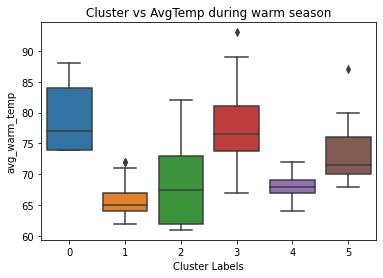

In [1001]:
ax = sns.boxplot(x='Cluster Labels', y='avg_warm_temp', data=cities_merged)
ax.set_title('Cluster vs AvgTemp during warm season')
plt.show()

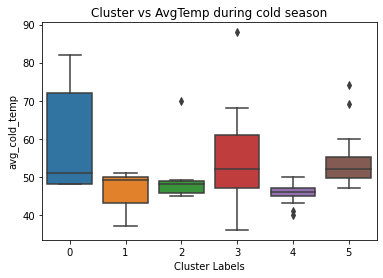

In [1002]:
ax = sns.boxplot(x='Cluster Labels', y='avg_cold_temp', data=cities_merged)
ax.set_title('Cluster vs AvgTemp during cold season')
plt.show()

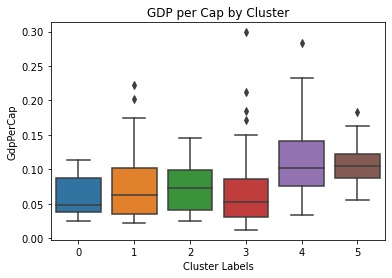

In [1003]:
ax = sns.boxplot(x='Cluster Labels', y='GdpPerCap', data=cities_merged)
ax.set_title('GDP per Cap by Cluster')
plt.show()

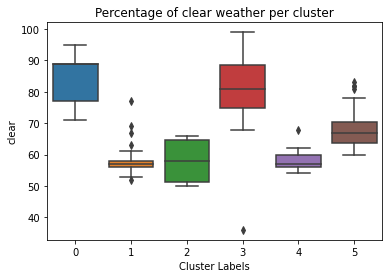

In [1004]:
ax = sns.boxplot(x='Cluster Labels', y='clear', data=cities_merged)
ax.set_title('Percentage of clear weather per cluster')
plt.show()

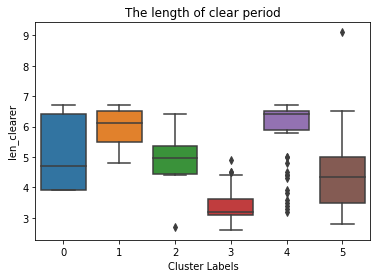

In [1005]:
ax = sns.boxplot(x='Cluster Labels', y='len_clearer', data=cities_merged)
ax.set_title('The length of clear period')
plt.show()

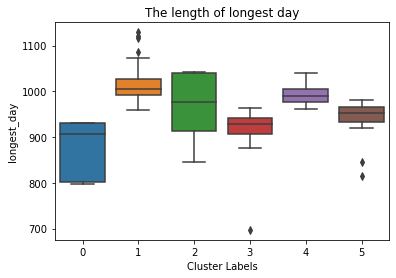

In [1006]:
ax = sns.boxplot(x='Cluster Labels', y='longest_day', data=cities_merged)
ax.set_title('The length of longest day')
plt.show()

Lets see the dependency between avg warm season tempreture and GdpPerCap.

<AxesSubplot:xlabel='avg_warm_temp', ylabel='GdpPerCap'>

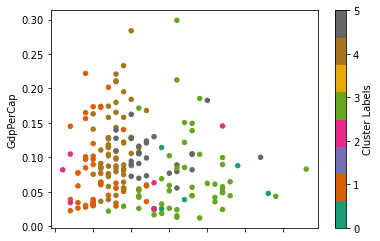

In [997]:
ax = cities_merged.plot.scatter(x='avg_warm_temp',y='GdpPerCap',c='Cluster Labels',colormap='Dark2')
ax.set_title('Cluster vs AvgTemp')
plt.show()

In [1009]:
print('I am glad to advise Bart that he can plan to go to any of the below cities:')
print(', '.join(list(suggestion.city)))

I am glad to advise Bart that he can plan to go to any of the below cities:
Manchester, Cambridge, Oxford, Exeter, Ipswich, Malmö, Stockholm, Göteborg, Düsseldorf, Leicester, Bruxelles, Gent, Coventry, Antwerpen, Middlesbrough, Bristol, Portsmouth, Kiel, Hamburg, Cardiff, Leeds, Uppsala, Southampton, Colchester, Ostrava, Doncaster, Bratislava, Swansea, Plzen, Liège, Praha, Brno, Berlin, Warszawa
